# Sing Me A Song - Complete Pipeline

This notebook demonstrates the complete auditory processing pipeline:
1. **Load Audio** - Load and preprocess WAV files
2. **Cochlear Filtering** - Simulate basilar membrane with filterbank
3. **Envelope Extraction** - Extract amplitude envelopes (basilar membrane motion)
4. **Hair Cell Transduction** - Nonlinear transformation
5. **Neural Spiking** - Simulate auditory nerve with LIF/HH neurons
6. **Visualization** - Plot spectrograms, cochleograms, spike rasters
7. **Reconstruction** - Decode spikes back to audio

In [1]:
# Import all necessary modules
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio, display

# Import project modules
import config
from audio_io.load_audio import load_audio
from audio_io.save_audio import save_audio
from cochlea.filterbank import apply_filterbank
from cochlea.envelope_extract import extract_envelopes_from_filterbank, downsample_envelopes
from haircell.transduction import apply_transduction
from neuron_models.neuron_population import simulate_population
from visualization import (plot_waveform, plot_spectrogram, plot_cochleogram,
                           plot_neurogram, plot_raster_by_channel, plot_firing_rates)
from reconstruction.decode_spikes import decode_to_envelopes
from reconstruction.vocoder import vocoder_reconstruct

# Configure matplotlib
plt.rcParams['figure.figsize'] = config.FIGURE_SIZE
plt.rcParams['figure.dpi'] = config.PLOT_DPI

print("✓ All modules imported successfully")
print(f"Configuration: {config.NUM_CHANNELS} channels, {config.LOW_FREQ}-{config.HIGH_FREQ} Hz")

✓ All modules imported successfully
Configuration: 192 channels, 80-8000 Hz


## Step 1: Load and Preprocess Audio

Load a WAV file from the `sound_db` folder, downsample to 16 kHz, and normalize.

In [2]:
# Load audio file - replace with your actual file name
audio_file = config.get_sound_file('test2.mp3')  # Change this to your file

# Load and preprocess
signal, fs = load_audio(audio_file, target_sr=config.TARGET_SAMPLE_RATE, normalize=True)

# Display basic info
duration = len(signal) / fs
print(f"Loaded audio: {audio_file}")
print(f"Duration: {duration:.2f} seconds")
print(f"Sample rate: {fs} Hz")
print(f"Signal shape: {signal.shape}")
print(f"Signal range: [{signal.min():.3f}, {signal.max():.3f}]")

# Play audio
display(Audio(signal, rate=fs))

Loaded audio: c:\Users\mohak\Documents\PROJECTS\sing-me-a-song\sound_db\test2.mp3
Duration: 24.65 seconds
Sample rate: 16000 Hz
Signal shape: (394389,)
Signal range: [-1.000, 0.931]


In [3]:
# OPTIONAL: Trim to first 10 seconds for faster testing
# Comment out these lines to process the full audio
TRIM_FOR_TESTING = True
if TRIM_FOR_TESTING:
    trim_samples = 10 * fs  # 10 seconds
    signal = signal[:trim_samples]
    duration = len(signal) / fs
    print(f"⚠ Trimmed to {duration:.1f} seconds for faster testing")

⚠ Trimmed to 10.0 seconds for faster testing


📊 Frequency Analysis:
  Sample rate: 16000 Hz (Nyquist: 8000.0 Hz)
  Max frequency with significant energy: 7786.0 Hz
  Energy above 8000 Hz: 0.0%
  Energy above 4000 Hz: 20.5%


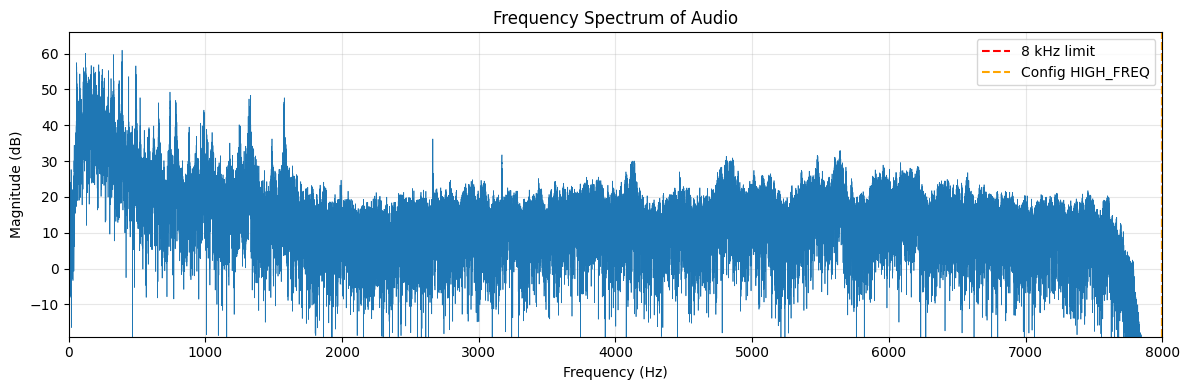

In [4]:
# Check frequency content of the audio
from scipy import fft

# Compute FFT
fft_vals = np.fft.rfft(signal)
fft_freq = np.fft.rfftfreq(len(signal), 1/fs)
fft_magnitude = np.abs(fft_vals)

# Find significant frequency content (above -60 dB)
magnitude_db = 20 * np.log10(fft_magnitude + 1e-10)
significant_freqs = fft_freq[magnitude_db > (magnitude_db.max() - 60)]

print(f"📊 Frequency Analysis:")
print(f"  Sample rate: {fs} Hz (Nyquist: {fs/2} Hz)")
print(f"  Max frequency with significant energy: {significant_freqs.max():.1f} Hz")
print(f"  Energy above 8000 Hz: {np.sum(fft_magnitude[fft_freq > 8000]) / np.sum(fft_magnitude) * 100:.1f}%")
print(f"  Energy above 4000 Hz: {np.sum(fft_magnitude[fft_freq > 4000]) / np.sum(fft_magnitude) * 100:.1f}%")

# Plot frequency spectrum
plt.figure(figsize=(12, 4))
plt.plot(fft_freq, magnitude_db, linewidth=0.5)
plt.axvline(x=8000, color='r', linestyle='--', label='8 kHz limit')
plt.axvline(x=config.HIGH_FREQ if hasattr(config, 'HIGH_FREQ') else 8000, color='orange', linestyle='--', label='Config HIGH_FREQ')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency Spectrum of Audio')
plt.xlim([0, fs/2])
plt.ylim([magnitude_db.max() - 80, magnitude_db.max() + 5])
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

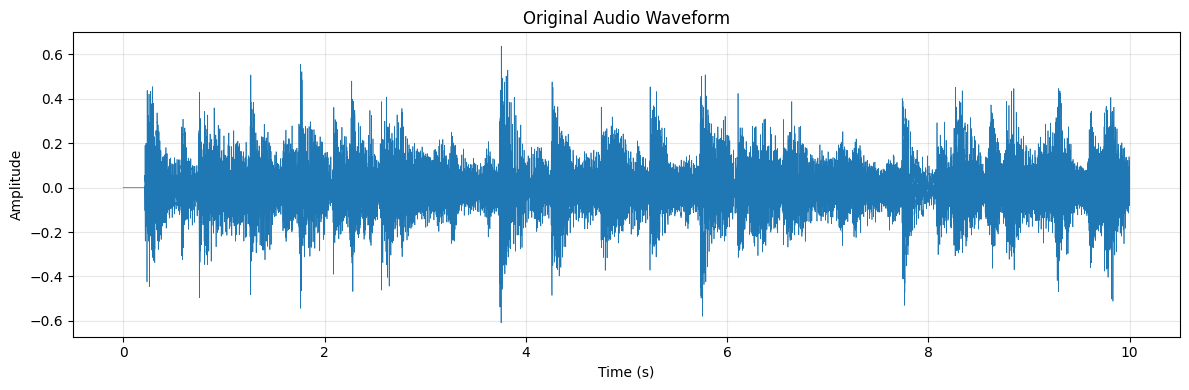

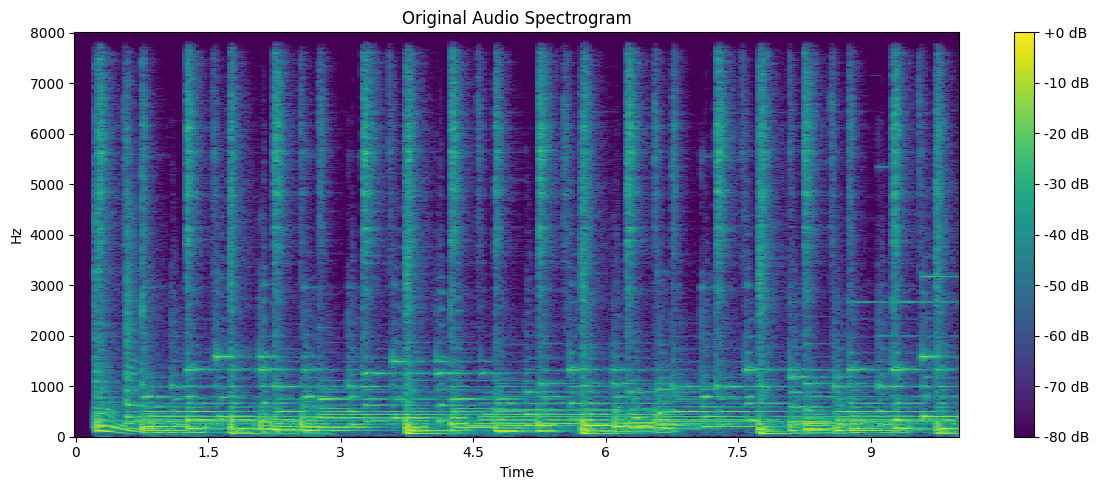

In [5]:
# Visualize the original waveform
plt.figure(figsize=(12, 4))
time_axis = np.arange(len(signal)) / fs
plt.plot(time_axis, signal, linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original Audio Waveform')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize spectrogram
plt.figure(figsize=(12, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
librosa.display.specshow(D, sr=fs, x_axis='time', y_axis='hz', cmap=config.CMAP_SPECTROGRAM)
plt.colorbar(format='%+2.0f dB')
plt.title('Original Audio Spectrogram')
plt.tight_layout()
plt.show()

## Step 2: Cochlear Filterbank

Apply a gammatone filterbank to decompose the signal into frequency channels, mimicking the basilar membrane.

In [6]:
# Apply gammatone filterbank
print("Applying cochlear filterbank...")
filtered_signals, center_freqs = apply_filterbank(
    signal, 
    fs, 
    num_channels=config.NUM_CHANNELS,
    low_freq=config.LOW_FREQ,
    high_freq=config.HIGH_FREQ
)

print(f"✓ Filterbank applied: {filtered_signals.shape[0]} channels")
print(f"  Channel frequencies: {center_freqs[0]:.1f} - {center_freqs[-1]:.1f} Hz")
print(f"  Output shape: {filtered_signals.shape} (channels × samples)")

Applying cochlear filterbank...
✓ Filterbank applied: 192 channels
  Channel frequencies: 80.0 - 8000.0 Hz
  Output shape: (192, 160000) (channels × samples)
✓ Filterbank applied: 192 channels
  Channel frequencies: 80.0 - 8000.0 Hz
  Output shape: (192, 160000) (channels × samples)


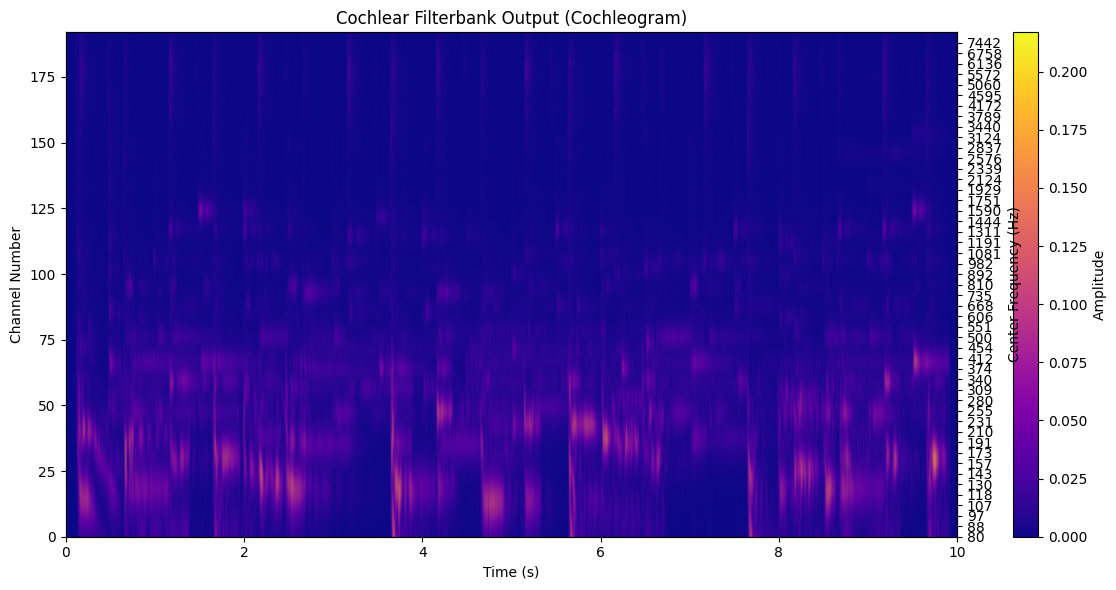

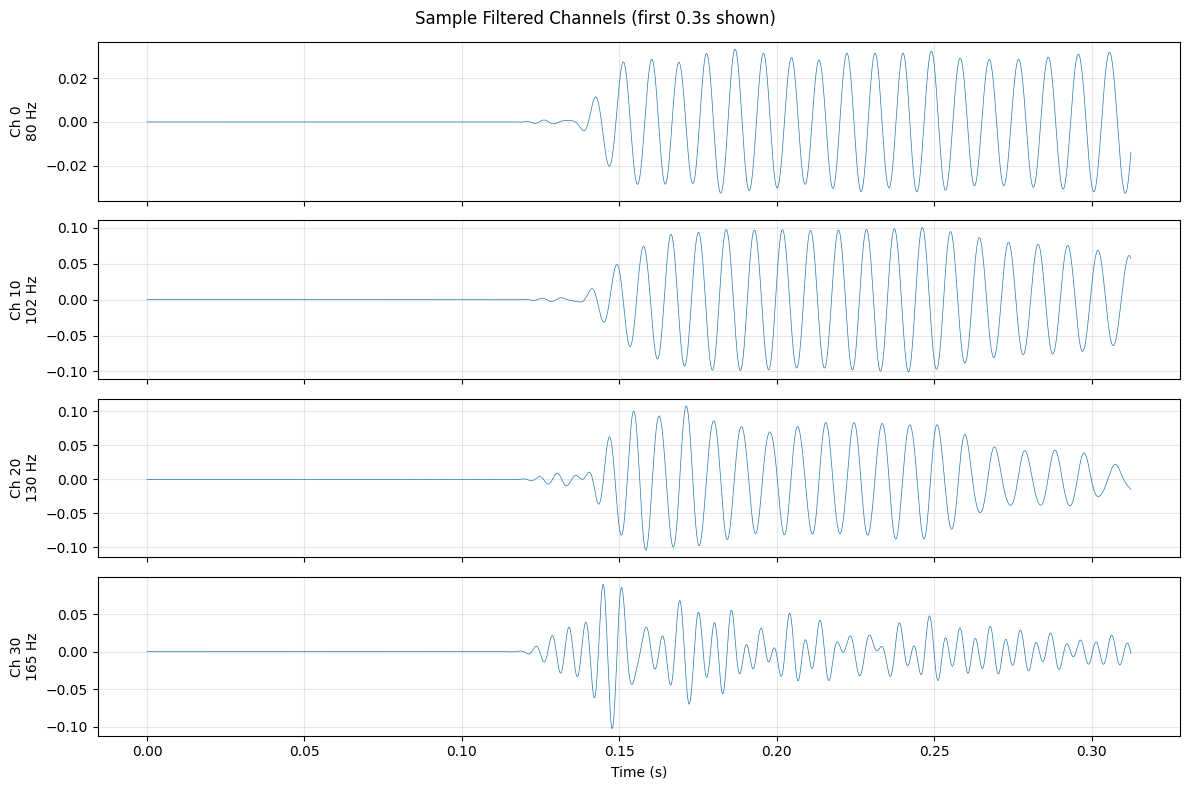

In [7]:
# Visualize cochlear filterbank output (cochleogram)
plt.figure(figsize=(12, 6))
extent = [0, duration, 0, config.NUM_CHANNELS]
plt.imshow(
    np.abs(filtered_signals), 
    aspect='auto', 
    origin='lower',
    extent=extent,
    cmap=config.CMAP_COCHLEA,
    interpolation='bilinear'
)
plt.colorbar(label='Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('Channel Number')
plt.title('Cochlear Filterbank Output (Cochleogram)')

# Add frequency labels on the right
ax = plt.gca()
ax2 = ax.twinx()
ax2.set_ylim(0, config.NUM_CHANNELS)
freq_ticks = np.arange(0, config.NUM_CHANNELS, 4)
freq_labels = [f"{center_freqs[int(i)]:.0f}" for i in freq_ticks if i < len(center_freqs)]
ax2.set_yticks(freq_ticks[:len(freq_labels)])
ax2.set_yticklabels(freq_labels)
ax2.set_ylabel('Center Frequency (Hz)')

plt.tight_layout()
plt.show()

# Plot a few individual channels
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
channels_to_plot = [0, 10, 20, 30]  # Low to high frequency
for idx, ch in enumerate(channels_to_plot):
    if ch < len(center_freqs):
        axes[idx].plot(time_axis[:5000], filtered_signals[ch, :5000], linewidth=0.5)
        axes[idx].set_ylabel(f'Ch {ch}\n{center_freqs[ch]:.0f} Hz')
        axes[idx].grid(True, alpha=0.3)
        if idx < 3:
            axes[idx].set_xticklabels([])
axes[-1].set_xlabel('Time (s)')
fig.suptitle('Sample Filtered Channels (first 0.3s shown)')
plt.tight_layout()
plt.show()

## Step 3: Extract Envelopes

Extract amplitude envelopes from each channel using the Hilbert transform. This represents the motion of the basilar membrane.

In [8]:
# Extract envelopes from all channels
print("Extracting envelopes...")
envelopes = extract_envelopes_from_filterbank(
    filtered_signals, 
    method=config.ENVELOPE_METHOD
)

print(f"✓ Envelopes extracted: {envelopes.shape}")

# Optional: Downsample envelopes for efficiency (envelopes vary slowly)
envelopes_downsampled, envelope_fs = downsample_envelopes(
    envelopes, 
    fs, 
    config.ENVELOPE_DOWNSAMPLE_RATE
)

print(f"✓ Envelopes downsampled: {envelopes_downsampled.shape}")
print(f"  New sampling rate: {envelope_fs} Hz")

Extracting envelopes...
✓ Envelopes extracted: (192, 160000)
✓ Envelopes extracted: (192, 160000)
✓ Envelopes downsampled: (192, 80000)
  New sampling rate: 8000 Hz
✓ Envelopes downsampled: (192, 80000)
  New sampling rate: 8000 Hz


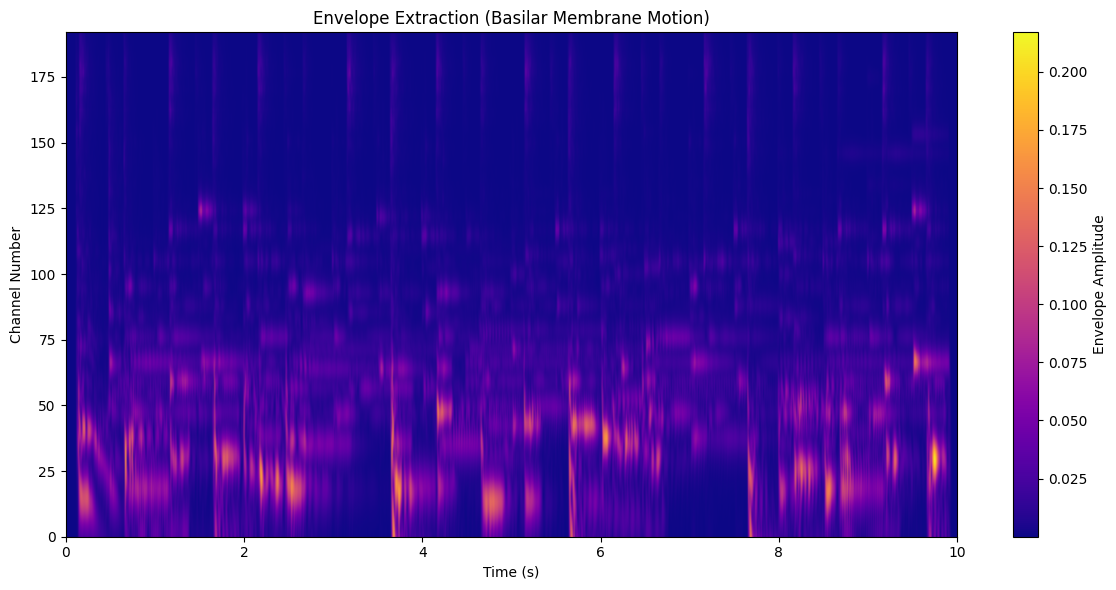

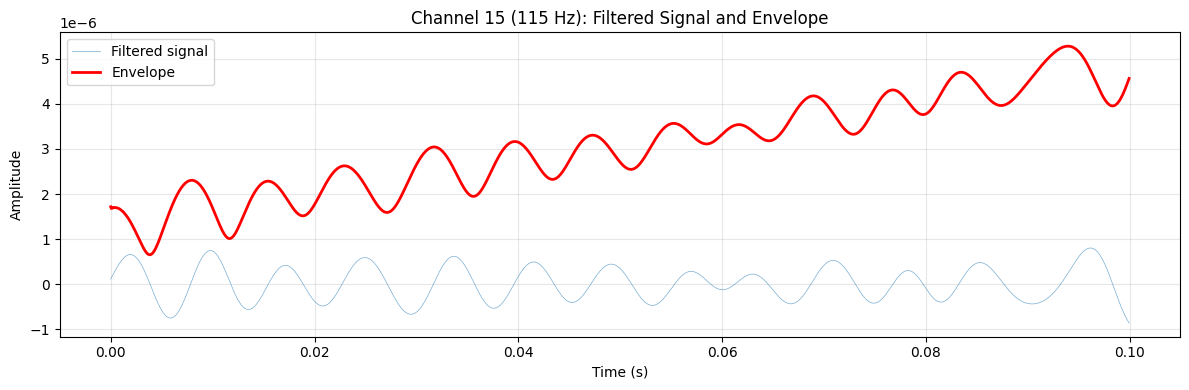

In [9]:
# Visualize envelopes
plt.figure(figsize=(12, 6))
envelope_duration = envelopes.shape[1] / fs
extent_env = [0, envelope_duration, 0, config.NUM_CHANNELS]
plt.imshow(
    envelopes, 
    aspect='auto', 
    origin='lower',
    extent=extent_env,
    cmap=config.CMAP_COCHLEA,
    interpolation='bilinear'
)
plt.colorbar(label='Envelope Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('Channel Number')
plt.title('Envelope Extraction (Basilar Membrane Motion)')
plt.tight_layout()
plt.show()

# Plot example: filtered signal vs its envelope
example_channel = 15
plt.figure(figsize=(12, 4))
time_window = slice(0, int(0.1 * fs))  # First 100ms
t = np.arange(len(filtered_signals[example_channel, time_window])) / fs

plt.plot(t, filtered_signals[example_channel, time_window], 
         alpha=0.6, linewidth=0.5, label='Filtered signal')
plt.plot(t, envelopes[example_channel, time_window], 
         color='red', linewidth=2, label='Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Channel {example_channel} ({center_freqs[example_channel]:.0f} Hz): Filtered Signal and Envelope')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

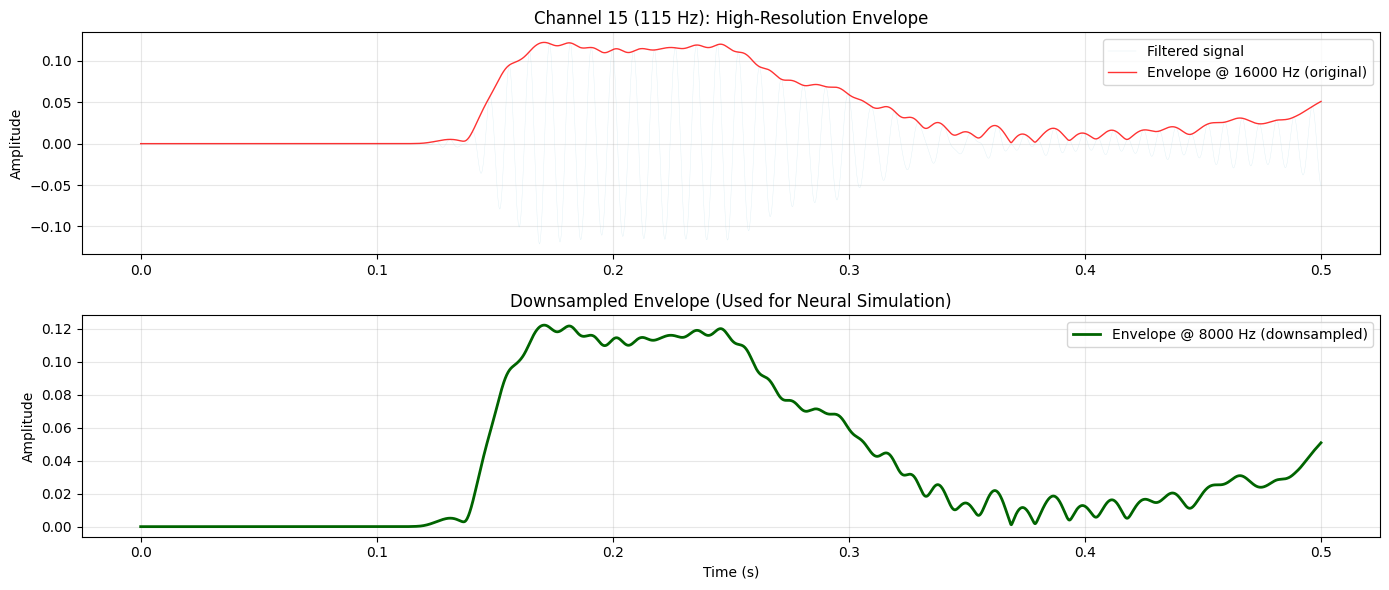

💡 Explanation:
  The 'noisy' appearance of the envelope in the first plot is normal!
  At 16 kHz sampling, even smooth envelope variations are highly detailed.
  The downsampled version (8000 Hz) is what drives the neurons - it's much smoother.
  Both represent the same underlying envelope, just at different temporal resolutions.


In [10]:
# Compare original vs downsampled envelope to show smoothing effect
example_channel = 15
plt.figure(figsize=(14, 6))

# Plot 1: Full resolution envelope (16 kHz) - looks "noisy"
plt.subplot(2, 1, 1)
time_window = slice(0, int(0.5 * fs))  # First 500ms
t_full = np.arange(len(envelopes[example_channel, time_window])) / fs
plt.plot(t_full, filtered_signals[example_channel, time_window], 
         alpha=0.4, linewidth=0.3, label='Filtered signal', color='lightblue')
plt.plot(t_full, envelopes[example_channel, time_window], 
         color='red', linewidth=1, label=f'Envelope @ {fs} Hz (original)', alpha=0.8)
plt.ylabel('Amplitude')
plt.title(f'Channel {example_channel} ({center_freqs[example_channel]:.0f} Hz): High-Resolution Envelope')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Downsampled envelope (2 kHz) - much smoother
plt.subplot(2, 1, 2)
downsample_window = int(0.5 * envelope_fs)
t_down = np.arange(downsample_window) / envelope_fs
plt.plot(t_down, envelopes_downsampled[example_channel, :downsample_window], 
         color='darkgreen', linewidth=2, label=f'Envelope @ {envelope_fs} Hz (downsampled)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Downsampled Envelope (Used for Neural Simulation)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"💡 Explanation:")
print(f"  The 'noisy' appearance of the envelope in the first plot is normal!")
print(f"  At 16 kHz sampling, even smooth envelope variations are highly detailed.")
print(f"  The downsampled version ({envelope_fs} Hz) is what drives the neurons - it's much smoother.")
print(f"  Both represent the same underlying envelope, just at different temporal resolutions.")

## Step 4: Hair Cell Transduction (Placeholder)

Apply nonlinear transformation simulating inner hair cell receptor potentials. This will be implemented in the `haircell` module.

In [11]:
# Apply hair cell transduction
print("Applying hair cell transduction...")
receptor_potentials = apply_transduction(
    envelopes,
    fs,
    compression_exp=config.COMPRESSION_EXPONENT,
    compression_thresh=config.COMPRESSION_THRESHOLD,
    adaptation_tau=config.ADAPTATION_TIME_CONSTANT,
    adaptation_strength=config.ADAPTATION_STRENGTH,
    apply_saturation=True
)

print(f"✓ Hair cell transduction complete: {receptor_potentials.shape}")
print(f"  Receptor potential range: [{receptor_potentials.min():.3f}, {receptor_potentials.max():.3f}]")

Applying hair cell transduction...
✓ Hair cell transduction complete: (192, 160000)
  Receptor potential range: [0.000, 1.000]
✓ Hair cell transduction complete: (192, 160000)
  Receptor potential range: [0.000, 1.000]


## Step 5: Neural Spiking Simulation (Placeholder)

Drive populations of LIF or Hodgkin-Huxley neurons with the receptor potentials. This will be implemented in the `neuron_models` module.

In [12]:
# Reload modules to pick up recent fixes
import importlib
import neuron_models.lif_neuron
importlib.reload(neuron_models.lif_neuron)
import neuron_models.neuron_population
importlib.reload(neuron_models.neuron_population)
print("✓ Modules reloaded")

✓ Modules reloaded


In [13]:
# Simulate neural population
print("Simulating neural population...")
print(f"  {config.NEURONS_PER_CHANNEL} neurons/channel × {config.NUM_CHANNELS} channels = {config.TOTAL_NEURONS} total neurons")

# Use downsampled envelopes for faster simulation
# This is much more efficient since envelopes vary slowly
# input_envelopes = envelopes_downsampled
# input_fs = envelope_fs
# print(f"  Using downsampled envelopes: {input_envelopes.shape} at {input_fs} Hz")

# Neuron parameters
neuron_params = {
    'tau_m': config.LIF_TAU_M,
    'v_threshold': config.LIF_V_THRESHOLD,
    'v_reset': config.LIF_V_RESET,
    'v_rest': config.LIF_V_REST,
    'refractory_period': config.LIF_REFRACTORY_PERIOD,
    'spontaneous_rate': config.SPONTANEOUS_RATE_MID,
    'input_scale': config.INPUT_CURRENT_SCALE
}

# Simulate population
spike_trains, firing_rates, population = simulate_population(
    receptor_potentials,
    # input_envelopes,
    config.SIMULATION_DT,
    config.NUM_CHANNELS,
    neurons_per_channel=config.NEURONS_PER_CHANNEL,
    neuron_params=neuron_params
)

print(f"✓ Neural simulation complete")
print(f"  Spike trains shape: {spike_trains.shape}")
print(f"  Firing rates shape: {firing_rates.shape}")
print(f"  Total spikes: {np.sum(spike_trains)}")

Simulating neural population...
  20 neurons/channel × 192 channels = 3840 total neurons
Simulating 3840 neurons...
  Completed 8/192 channels
  Completed 8/192 channels
  Completed 16/192 channels
  Completed 16/192 channels
  Completed 24/192 channels
  Completed 24/192 channels
  Completed 32/192 channels
  Completed 32/192 channels
  Completed 40/192 channels
  Completed 40/192 channels
  Completed 48/192 channels
  Completed 48/192 channels
  Completed 56/192 channels
  Completed 56/192 channels
  Completed 64/192 channels
  Completed 64/192 channels
  Completed 72/192 channels
  Completed 72/192 channels
  Completed 80/192 channels
  Completed 80/192 channels
  Completed 88/192 channels
  Completed 88/192 channels
  Completed 96/192 channels
  Completed 96/192 channels
  Completed 104/192 channels
  Completed 104/192 channels
  Completed 112/192 channels
  Completed 112/192 channels
  Completed 120/192 channels
  Completed 120/192 channels
  Completed 128/192 channels
  Completed

## Step 6: Visualization (Placeholder)

Create comprehensive visualizations of the pipeline stages. This will be implemented in the `visualization` module.

Creating visualizations...


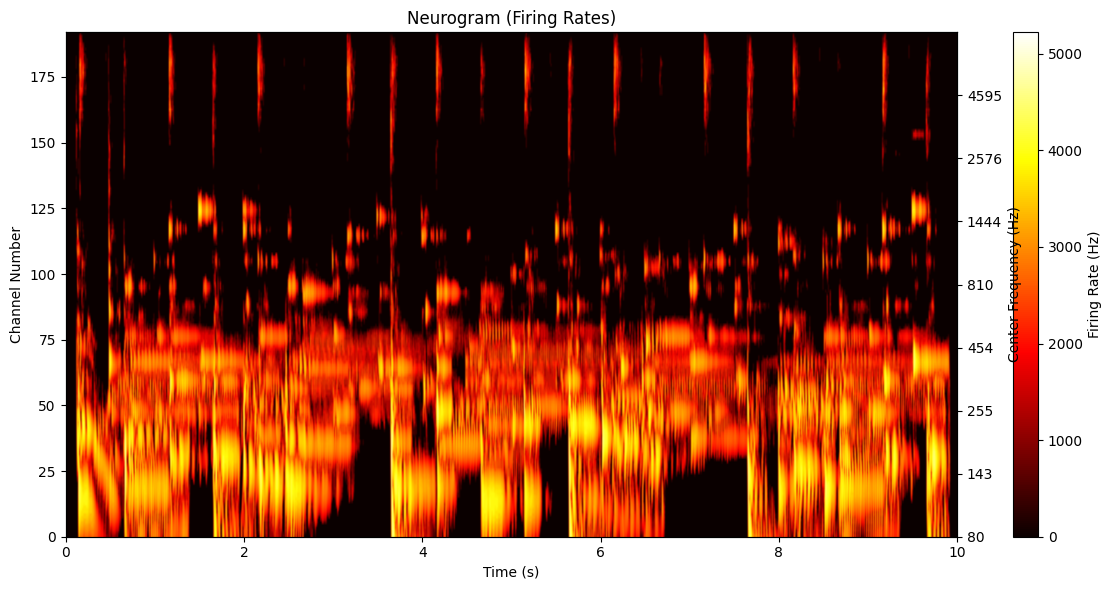

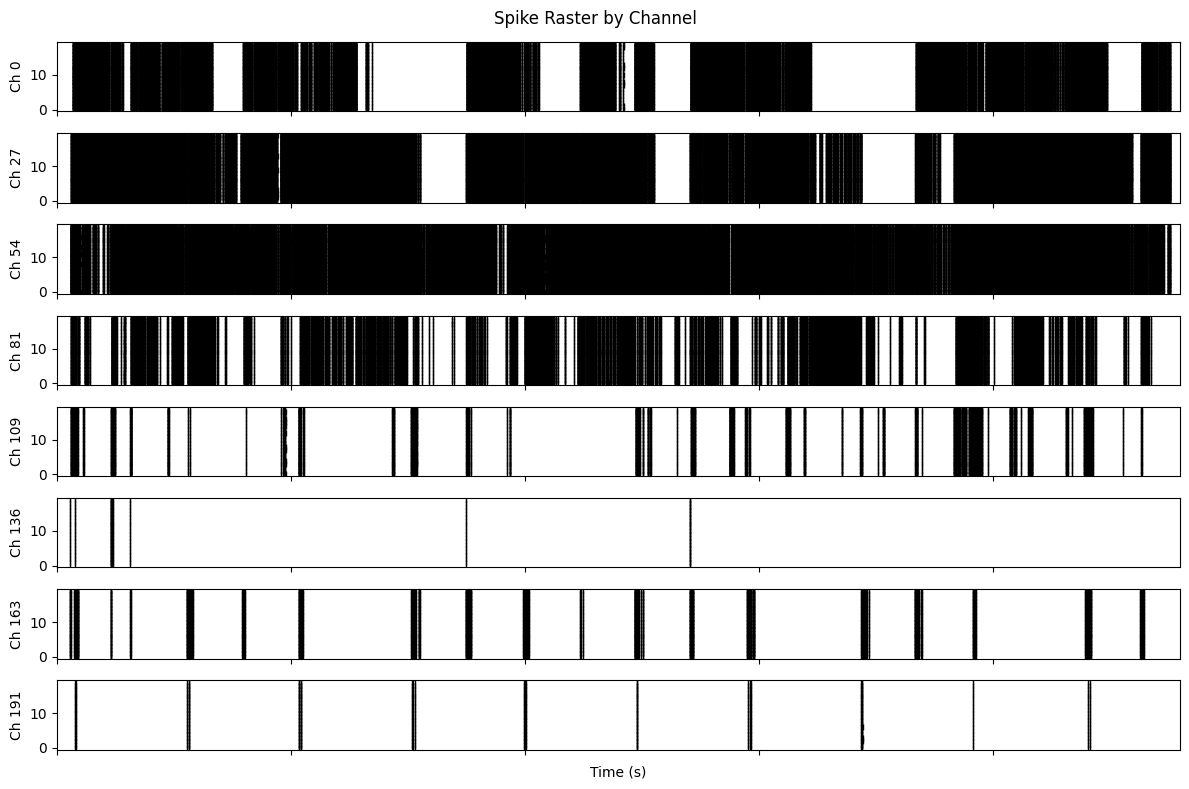

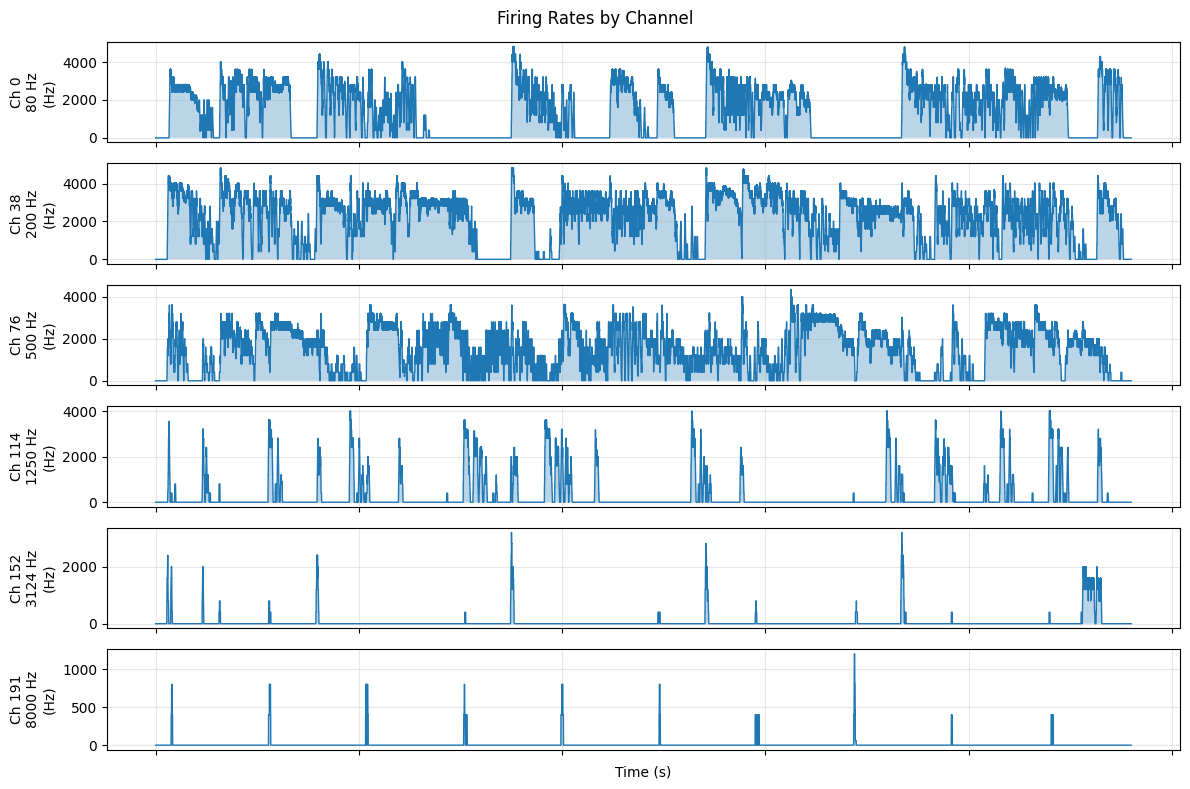

✓ Visualizations complete


In [14]:
# Visualize neural activity
print("Creating visualizations...")

# Neurogram (firing rate heatmap)
plot_neurogram(firing_rates, duration, center_freqs, title='Neurogram (Firing Rates)')
plt.show()

# Spike raster by channel
plot_raster_by_channel(spike_trains, config.NEURONS_PER_CHANNEL, config.SIMULATION_DT)
plt.show()

# Firing rates for selected channels
plot_firing_rates(firing_rates, config.SIMULATION_DT, center_freqs=center_freqs)
plt.show()

print("✓ Visualizations complete")

## Step 7: Audio Reconstruction (Placeholder)

Reconstruct audio from neural spike trains using vocoder techniques. This will be implemented in the `reconstruction` module.

In [15]:
# Reconstruct audio from firing rates
print("Reconstructing audio from neural activity...")

# Step 1: Convert firing rates to envelopes with smoothing
from scipy.ndimage import gaussian_filter1d

# Normalize firing rates to [0, 1] range
reconstructed_envelopes = firing_rates / np.max(firing_rates)

# Apply gentle smoothing to envelopes for more natural sound
# (sigma=2 means ~2ms smoothing at 2kHz envelope rate)
for ch in range(reconstructed_envelopes.shape[0]):
    reconstructed_envelopes[ch, :] = gaussian_filter1d(reconstructed_envelopes[ch, :], sigma=2)

# Step 2: Calculate target RMS from original signal
original_rms = np.sqrt(np.mean(signal**2))

# Step 3: Use vocoder to synthesize audio with RMS matching
reconstructed_audio = vocoder_reconstruct(
    reconstructed_envelopes,
    center_freqs,
    fs,
    method=config.VOCODER_CARRIER_TYPE,  # 'noise' or 'sine'
    normalize=True,
    target_rms=original_rms * 0.7  # Match 70% of original RMS to avoid harsh sound
)

print(f"✓ Audio reconstructed: {len(reconstructed_audio)} samples")
print(f"  Duration: {len(reconstructed_audio)/fs:.2f} seconds")
print(f"  Range: [{reconstructed_audio.min():.3f}, {reconstructed_audio.max():.3f}]")
reconstructed_rms = np.sqrt(np.mean(reconstructed_audio**2))
print(f"  Original RMS: {original_rms:.4f}")
print(f"  Reconstructed RMS: {reconstructed_rms:.4f} ({reconstructed_rms/original_rms*100:.1f}% of original)")

# Play reconstructed audio
print("\n🔊 Reconstructed audio:")
display(Audio(reconstructed_audio, rate=fs))

# Save reconstructed audio
output_path = config.OUTPUT_PATH
config.ensure_output_dir()
save_audio(reconstructed_audio, fs, f"{output_path}/reconstructed_audio.wav")
print(f"✓ Saved to {output_path}/reconstructed_audio.wav")

Reconstructing audio from neural activity...
✓ Audio reconstructed: 160000 samples
  Duration: 10.00 seconds
  Range: [-0.631, 0.601]
  Original RMS: 0.1004
  Reconstructed RMS: 0.0703 (70.0% of original)

🔊 Reconstructed audio:
✓ Audio reconstructed: 160000 samples
  Duration: 10.00 seconds
  Range: [-0.631, 0.601]
  Original RMS: 0.1004
  Reconstructed RMS: 0.0703 (70.0% of original)

🔊 Reconstructed audio:


✓ Saved to c:\Users\mohak\Documents\PROJECTS\sing-me-a-song\output/reconstructed_audio.wav


## Step 8: Compare Original vs Reconstructed

Compare the original and reconstructed audio side-by-side.

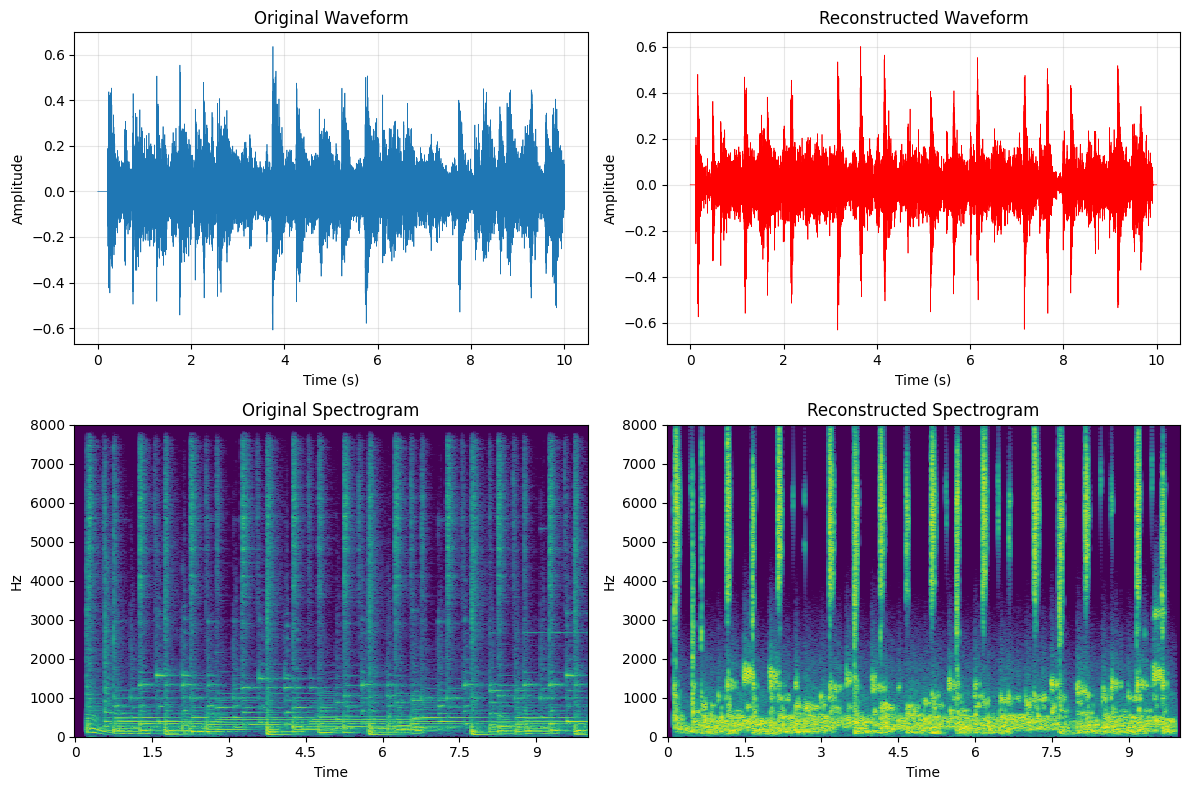


📊 Comparison Summary:
  Original duration: 10.00s
  Reconstructed duration: 10.00s
  Original RMS: 0.1004
  Reconstructed RMS: 0.0703

🔊 Original audio:


In [16]:
# Visual comparison
from visualization.spectrograms import plot_comparison

# Ensure signals are same length for comparison
min_len = min(len(signal), len(reconstructed_audio))
plot_comparison(signal[:min_len], reconstructed_audio[:min_len], fs)
plt.show()

print("\n📊 Comparison Summary:")
print(f"  Original duration: {len(signal)/fs:.2f}s")
print(f"  Reconstructed duration: {len(reconstructed_audio)/fs:.2f}s")
print(f"  Original RMS: {np.sqrt(np.mean(signal**2)):.4f}")
print(f"  Reconstructed RMS: {np.sqrt(np.mean(reconstructed_audio**2)):.4f}")

# Play original again for comparison
print("\n🔊 Original audio:")
display(Audio(signal, rate=fs))

## 🎉 Pipeline Complete!

You've successfully simulated the complete auditory processing pipeline:
1. ✓ Loaded and preprocessed audio
2. ✓ Applied cochlear filterbank (32 channels)
3. ✓ Extracted envelopes (basilar membrane motion)
4. ✓ Simulated hair cell transduction
5. ✓ Generated neural spike trains (320 neurons)
6. ✓ Visualized neural responses
7. ✓ Reconstructed audio from spikes

**Next Steps:**
- Try different audio files
- Adjust parameters in `config.py`
- Experiment with different neuron types (HH vs LIF)
- Compare noise vs sine vocoder reconstruction
- Analyze reconstruction quality metrics